# Project: Berlin Rent Index vs. German Inflation  
*Hypothesis Test: Does rent change mirror inflation?*

## 1. Hypothesis
- **H₀**: Annual rent index change = Inflation rate (μ_rent = μ_inflation)

    *The annual % change in Berlin's rent index = Germany's inflation rate*  
  (Mathematically: μ_rent = μ_inflation)

- **H₁**: Annual rent index change ≠ Inflation rate (μ_rent ≠ μ_inflation)

    *The annual % change in Berlin's rent index ≠ Germany's inflation rate*  
  (Mathematically: μ_rent ≠ μ_inflation)

#### Import Libraries:


In [1]:
### Import Libraries
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import glob # for file handling
import os # for file handling
import sys # for file handling


In [2]:
# DFs Setups
# 1. code to display the all the rows of the DataFrame

# pd.set_option('display.max_rows', None)  # Show all rows

# 2. disable showing all rows, set it back to default
pd.set_option('display.max_rows', 10)  # Show only 10 rows by default

## 2. Data Loading

### 2.1 Rent Data (Mietspiegel)

In [3]:
# Load individual rent files (corrected)
rent_2023 = pd.read_csv("../data/raw/Mietspiegel_Berlin_2023.csv").iloc[:, 1:]
rent_2023["survey_year"] = 2023

rent_2021 = pd.read_csv("../data/raw/Mietspiegel_Berlin_2021.csv").iloc[:, 1:]
rent_2021["survey_year"] = 2021

rent_2019 = pd.read_csv("../data/raw/Mietspiegel_Berlin_2019.csv").iloc[:, 1:]
rent_2019["survey_year"] = 2019

rent_2017 = pd.read_csv("../data/raw/Mietspiegel_Berlin_2017.csv").iloc[:, 1:]
rent_2017["survey_year"] = 2017

# Combine DataFrames
rent_all = pd.concat(
    [rent_2023, rent_2021, rent_2019, rent_2017],
    ignore_index=True   # Reset index
)

In [4]:
# Correct column names based on your description
rent_all = rent_all.rename(columns={
    "Size": "size",
    "Quality": "location_quality",  # Renamed here
    "Year": "construction_period",  # More accurate name
    "Mean": "median_rent_per_m2",
    "Min": "lower_bound_per_m2",
    "Max": "upper_bound_per_m2",
})

In [5]:
# Translate location quality values
translation_map = {'einfach': 'low', 'mittel': 'medium', 'gut': 'high'}
rent_all["location_quality"] = rent_all["location_quality"].map(translation_map)

In [6]:
# 3. Verify translation
print(rent_all["location_quality"].unique())  # Should show: ['low', 'medium', 'high']

['low' 'medium' 'high']


In [7]:
rent_all

,size,location_quality,construction_period,median_rent_per_m2,lower_bound_per_m2,upper_bound_per_m2,survey_year
0,<40 m2,low,bis 1918,8.42,5.86,13.82,2023
1,<40 m2,low,1919–1949,8.32,6.40,9.25,2023
2,<40 m2,low,1950–1964,6.85,5.90,9.62,2023
3,<40 m2,low,1965–1972,7.24,6.39,9.41,2023
4,<40 m2,low,1973–1990 West,8.06,7.92,9.43,2023
...,...,...,...,...,...,...,...
354,90+ m²,high,1965–1972,8.05,6.99,8.54,2017
355,90+ m²,high,1973–1990 West,8.83,7.60,10.49,2017
356,90+ m²,high,1973–1990 Ost,5.63,5.24,6.92,2017
357,90+ m²,high,1991–2002,9.24,7.18,11.13,2017


---
### DataFrame 'tests'

In [8]:
rent_all.info()  # Get DataFrame info
nulls = rent_all.isnull().sum()  # Check for missing values
duplicated = rent_all.duplicated().sum()  # Check for duplicates

# print("DataFrame shape: ", rent_all.shape, "\n")
print("\nMissing values: ", nulls, "\n")
print("Duplicate rows: ", duplicated)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   size                 359 non-null    object 
 1   location_quality     359 non-null    object 
 2   construction_period  359 non-null    object 
 3   median_rent_per_m2   359 non-null    float64
 4   lower_bound_per_m2   359 non-null    float64
 5   upper_bound_per_m2   359 non-null    float64
 6   survey_year          359 non-null    int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 19.8+ KB

Missing values:  size                   0
location_quality       0
construction_period    0
median_rent_per_m2     0
lower_bound_per_m2     0
upper_bound_per_m2     0
survey_year            0
dtype: int64 

Duplicate rows:  0


### 2.2 Inflation Data (World Bank)

In [9]:
# Load World Bank CSV
inflation = pd.read_csv("../data/raw/world_bank_inflation.csv", skiprows=4) # Skip metadata rows

In [10]:
inflation.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.931196,-1.028282,3.626041,4.257462,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,6.596505,6.399343,4.720805,4.644967,5.405162,7.240978,10.773751,7.126975,NaN,NaN
2,Afghanistan,AFG,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,4.383892,4.975952,0.626149,2.302373,5.601888,5.133203,13.712102,-4.644709,-6.601186,NaN
3,Africa Western and Central,AFW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,1.487416,1.725486,1.784050,1.983092,2.490378,3.745700,7.949251,5.221168,NaN,NaN
4,Angola,AGO,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,30.694415,29.844480,19.628938,17.080954,22.271539,25.754295,21.355290,13.644102,28.240495,NaN


---
## 3. Data Processing
### 3.1 Rent Data: Calculate Yearly Averages


In [11]:
# Calculate yearly median rent (grouped by survey year)
yearly_median = (
    rent_all
    .groupby("survey_year")
    ["median_rent_per_m2"]
    .median()
    .reset_index()
    .sort_values("survey_year", ascending=False)
)

# Calculate yearly average bounds for context
yearly_bounds = (
    rent_all
    .groupby("survey_year")
    .agg(
        avg_lower_bound=("lower_bound_per_m2", "mean"),
        avg_upper_bound=("upper_bound_per_m2", "mean")
    )
    .reset_index()
)

# Combine results
yearly_rent = pd.merge(yearly_median, yearly_bounds, on="survey_year")
yearly_rent.columns = [
    "survey_year", 
    "city_median_rent_per_m2", 
    "avg_lower_bound_per_m2", 
    "avg_upper_bound_per_m2"
]

display(yearly_rent)

,survey_year,city_median_rent_per_m2,avg_lower_bound_per_m2,avg_upper_bound_per_m2
0,2023,7.61,6.597640,9.773708
1,2021,7.22,6.259213,9.272697
2,2019,7.14,6.191236,9.171685
3,2017,6.86,6.043043,8.969457


In [12]:
# Export cleaned yearly rent median city wide
yearly_rent.to_csv(
    "../data/processed/berlin_annual_rent_index_2017-2023.csv",
    index=False
)

### 3.2 Inflation Data: Filter for Germany


In [13]:
# 1. Filter for Germany and relevant indicator
germany_inflation = inflation[
    (inflation["Country Name"] == "Germany") &
    (inflation["Indicator Name"] == "Inflation, consumer prices (annual %)")
]

In [14]:
germany_inflation

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
55,Germany,DEU,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,1.536612,2.293695,2.84327,2.96696,2.335736,3.242319,...,0.491747,1.509495,1.732169,1.44566,0.144878,3.066667,6.872574,5.946437,2.256498,NaN


In [15]:
# 2. Melt to convert year columns into rows
inflation_melted = germany_inflation.melt(
    id_vars=["Country Name", "Indicator Name"],
    var_name="year",
    value_name="inflation_rate"
)
inflation_melted

,Country Name,Indicator Name,year,inflation_rate
0,Germany,"Inflation, consumer prices (annual %)",Country Code,DEU
1,Germany,"Inflation, consumer prices (annual %)",Indicator Code,FP.CPI.TOTL.ZG
2,Germany,"Inflation, consumer prices (annual %)",1960,1.536612
3,Germany,"Inflation, consumer prices (annual %)",1961,2.293695
4,Germany,"Inflation, consumer prices (annual %)",1962,2.84327
...,...,...,...,...
63,Germany,"Inflation, consumer prices (annual %)",2021,3.066667
64,Germany,"Inflation, consumer prices (annual %)",2022,6.872574
65,Germany,"Inflation, consumer prices (annual %)",2023,5.946437
66,Germany,"Inflation, consumer prices (annual %)",2024,2.256498


In [16]:
# 3. Clean and format columns
inflation_clean = (
    inflation_melted
    .rename(columns={"Country Name": "country"})
    .drop(columns=["Indicator Name"])  # Remove unnecessary column
)

In [17]:
# 4. Filter out non-year rows and convert to numeric
# Keep only rows where 'year' is a 4-digit number
inflation_clean = inflation_clean[inflation_clean["year"].str.match(r'^\d{4}$', na=False)]

In [18]:
# Convert year to integer and inflation_rate to float
inflation_clean["year"] = inflation_clean["year"].astype(int)
inflation_clean["inflation_rate"] = pd.to_numeric(
    inflation_clean["inflation_rate"], 
    errors="coerce"  # Convert non-numeric to NaN
)

In [19]:
inflation_clean

,country,year,inflation_rate
2,Germany,1960,1.536612
3,Germany,1961,2.293695
4,Germany,1962,2.843270
5,Germany,1963,2.966960
6,Germany,1964,2.335736
...,...,...,...
62,Germany,2020,0.144878
63,Germany,2021,3.066667
64,Germany,2022,6.872574
65,Germany,2023,5.946437


In [20]:
# Check the cleaned DataFrame

inflation_clean.info()  # Get DataFrame info
nulls = inflation_clean.isnull().sum()  # Check for missing values
duplicated = inflation_clean.duplicated().sum()  # Check for duplicates

# print("DataFrame shape: ", rent_all.shape, "\n")
print("\nMissing values: ", nulls, "\n")
print("Duplicate rows: ", duplicated)

<class 'pandas.core.frame.DataFrame'>
Index: 65 entries, 2 to 66
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         65 non-null     object 
 1   year            65 non-null     int64  
 2   inflation_rate  65 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.0+ KB

Missing values:  country           0
year              0
inflation_rate    0
dtype: int64 

Duplicate rows:  0


In [21]:
# Export cleaned annual inflation data
inflation_clean.to_csv(
    "../data/processed/germany_annual_inflation_2017-2023.csv", 
    index=False
)

#### DataFrame is clean and without Nulls

### 3.3 Inflation Data Germany: Filter the survey years/Calculate Biennal


In [22]:
# Filter relevant years (2017-2023) and sort
inflation_clean_survey = inflation_clean.copy()

inflation_clean_survey = inflation_clean_survey[
    (inflation_clean_survey["year"] >= 2017) & 
    (inflation_clean_survey["year"] <= 2023)
].sort_values("year")


In [23]:
inflation_clean_survey

,country,year,inflation_rate
59,Germany,2017,1.509495
60,Germany,2018,1.732169
61,Germany,2019,1.445660
62,Germany,2020,0.144878
63,Germany,2021,3.066667
64,Germany,2022,6.872574
65,Germany,2023,5.946437


In [24]:
# Step 1: Define survey periods

# Calculate cumulative biennial inflation
biennial_periods = []
survey_years = [2017, 2019, 2021, 2023]

# Step 2: Loop through each survey period
for i in range(len(survey_years)-1):
    start_year = survey_years[i]
    end_year = survey_years[i+1]
    
    # Step 3: Get inflation for years BETWEEN surveys
    # For 2017-2019 period: we need 2018 and 2019 inflation
    period_inflation = inflation_clean_survey[
        (inflation_clean_survey["year"] > start_year) & 
        (inflation_clean_survey["year"] <= end_year)
    ]["inflation_rate"]  # Use "inflation_rate" column name
    
    # Step 4: Calculate cumulative inflation
    # Calculate cumulative effect
    cumulative_factor = 1
    for rate in period_inflation:
        # Handle NaN values
        if not pd.isna(rate):
            # Convert % to multiplier: 5% → 1.05
            cumulative_factor *= (1 + rate/100)

    # Step 5: Convert back to percentage
    cumulative_inflation = (cumulative_factor - 1) * 100
    
    # Step 6: Store results with clear period labels
    biennial_periods.append({
        "start_year": start_year,
        "end_year": end_year,
        "inflation_biennial_pct": cumulative_inflation,
        "period_years": f"{start_year+1}-{end_year}"    # Years inflation was active
    })

# Create biennial inflation DataFrame
inflation_biennial = pd.DataFrame(biennial_periods)
print(inflation_biennial)

   start_year  end_year  inflation_biennial_pct period_years
0        2017      2019                3.202870    2018-2019
1        2019      2021                3.215988    2020-2021
2        2021      2023               13.227684    2022-2023


---
## 4. Merge Datasets

### 4.1 Rent index Align by Year and Calculate Annual Changes

In [25]:
yearly_rent

,survey_year,city_median_rent_per_m2,avg_lower_bound_per_m2,avg_upper_bound_per_m2
0,2023,7.61,6.597640,9.773708
1,2021,7.22,6.259213,9.272697
2,2019,7.14,6.191236,9.171685
3,2017,6.86,6.043043,8.969457


In [26]:
# Sort rent data by year (ascending for pct_change)
yearly_rent_sorted = yearly_rent.sort_values("survey_year")
display(yearly_rent_sorted)

,survey_year,city_median_rent_per_m2,avg_lower_bound_per_m2,avg_upper_bound_per_m2
3,2017,6.86,6.043043,8.969457
2,2019,7.14,6.191236,9.171685
1,2021,7.22,6.259213,9.272697
0,2023,7.61,6.597640,9.773708


### 4.2 Calculate Rent Biennial percentage increase


In [27]:
# Calculate biennial rent changes (% change from previous survey)
yearly_rent_sorted["rent_change_pct"] = (
    yearly_rent_sorted["city_median_rent_per_m2"]
    .pct_change()
    * 100
)
display(yearly_rent_sorted)

,survey_year,city_median_rent_per_m2,avg_lower_bound_per_m2,avg_upper_bound_per_m2,rent_change_pct
3,2017,6.86,6.043043,8.969457,NaN
2,2019,7.14,6.191236,9.171685,4.081633
1,2021,7.22,6.259213,9.272697,1.120448
0,2023,7.61,6.597640,9.773708,5.401662


In [28]:
# Calculate biennial rent changes (% change from previous survey)
yearly_rent_sorted["rent_change_pct"] = (
    yearly_rent_sorted["city_median_rent_per_m2"]
    .pct_change()
    * 100
)
display(yearly_rent_sorted)

,survey_year,city_median_rent_per_m2,avg_lower_bound_per_m2,avg_upper_bound_per_m2,rent_change_pct
3,2017,6.86,6.043043,8.969457,NaN
2,2019,7.14,6.191236,9.171685,4.081633
1,2021,7.22,6.259213,9.272697,1.120448
0,2023,7.61,6.597640,9.773708,5.401662


In [29]:
# Add end_year column for merging
rent_changes = yearly_rent_sorted.copy()
rent_changes["end_year"] = rent_changes["survey_year"]
rent_changes["start_year"] = rent_changes["survey_year"].shift(1)
display(rent_changes)

,survey_year,city_median_rent_per_m2,avg_lower_bound_per_m2,avg_upper_bound_per_m2,rent_change_pct,end_year,start_year
3,2017,6.86,6.043043,8.969457,NaN,2017,NaN
2,2019,7.14,6.191236,9.171685,4.081633,2019,2017.0
1,2021,7.22,6.259213,9.272697,1.120448,2021,2019.0
0,2023,7.61,6.597640,9.773708,5.401662,2023,2021.0


In [30]:
# Remove first row (no change value)
rent_changes = rent_changes.dropna().reset_index(drop=True)
rent_changes["start_year"] = rent_changes["start_year"].astype(int)
display(rent_changes)

,survey_year,city_median_rent_per_m2,avg_lower_bound_per_m2,avg_upper_bound_per_m2,rent_change_pct,end_year,start_year
0,2019,7.14,6.191236,9.171685,4.081633,2019,2017
1,2021,7.22,6.259213,9.272697,1.120448,2021,2019
2,2023,7.61,6.597640,9.773708,5.401662,2023,2021


In [31]:
# Keep relevant columns
rent_changes = rent_changes[["start_year", "end_year", "rent_change_pct"]]
display(rent_changes)

,start_year,end_year,rent_change_pct
0,2017,2019,4.081633
1,2019,2021,1.120448
2,2021,2023,5.401662


### 4.3 Merge Rent Changes with Inflation Data


In [32]:
display(inflation_biennial)

,start_year,end_year,inflation_biennial_pct,period_years
0,2017,2019,3.202870,2018-2019
1,2019,2021,3.215988,2020-2021
2,2021,2023,13.227684,2022-2023


In [33]:
# Merge the rent changes with biennial inflation data
df_final = pd.merge(
    rent_changes[["start_year", "end_year", "rent_change_pct"]],
    inflation_biennial,
    on=["start_year", "end_year"]
)
display(df_final)

,start_year,end_year,rent_change_pct,inflation_biennial_pct,period_years
0,2017,2019,4.081633,3.202870,2018-2019
1,2019,2021,1.120448,3.215988,2020-2021
2,2021,2023,5.401662,13.227684,2022-2023


---
## 5. Hypothesis Testing (Paired t-test)

### 5.1 Test Setup

In [34]:
# Perform paired t-test
t_stat, p_value = stats.ttest_rel(
    df_final["rent_change_pct"], 
    df_final["inflation_biennial_pct"]
)

print("Hypothesis Test Results:")
print(f"t-statistic = {t_stat:.4f}")
print(f"p-value = {p_value:.4f}")

Hypothesis Test Results:
t-statistic = -1.1800
p-value = 0.3593


In [35]:
# Perform paired t-test
t_stat, p_value = stats.ttest_rel(
    df_final["rent_change_pct"], 
    df_final["inflation_biennial_pct"],
    alternative='less'  # One-tailed test: rent change > inflation

)

print("Hypothesis Test Results:")
print(f"t-statistic = {t_stat:.4f}")
print(f"p-value = {p_value:.4f}")

Hypothesis Test Results:
t-statistic = -1.1800
p-value = 0.1797


In [36]:
from scipy import stats

rent_changes = [4.08, 1.12, 5.40]
inflation_changes = [3.20, 3.22, 13.23]

# Incorrect independent test
t_ind, p_ind = stats.ttest_ind(rent_changes, inflation_changes)
print(f"Independent t-test: t={t_ind:.2f}, p={p_ind:.4f}")

Independent t-test: t=-0.84, p=0.4459


### 5.2 Results Interpretation

In [37]:
# Interpret results
alpha = 0.05
if p_value < alpha:
    print("\nConclusion: Reject H₀ (p < 0.05)")
    print("There is a significant difference between rent changes and inflation")
else:
    print("\nConclusion: Fail to reject H₀")
    print("No significant difference found")


Conclusion: Fail to reject H₀
No significant difference found


### 5.3 Power Analysis: Determining Required Sample Size

In [38]:
import numpy as np

# Differences between rent change and inflation change (rent_change - inflation)
differences = np.array([4.08 - 3.20,   # 2017-2019
                        1.12 - 3.22,  # 2019-2021
                        5.40 - 13.23]) # 2021-2023

mean_diff = np.mean(differences)  # ≈ -3.02
std_diff = np.std(differences, ddof=1)  # ≈ 4.43

# Cohen's d = mean difference / standard deviation
cohens_d = abs(mean_diff) / std_diff  # new 0.68
print(f"Cohen's d effect size: {cohens_d:.2f}")



Cohen's d effect size: 0.68


In [39]:
std_diff

4.42676330215806

In [40]:
from statsmodels.stats.power import TTestPower

# Parameters
effect_size = cohens_d  # From your data
alpha = 0.05         # Standard significance level
power = 0.80         # Standard desired power (80% chance to detect true effect)

# Calculate required sample size
analysis = TTestPower()
sample_size = analysis.solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=power,
    alternative='two-sided'  # For H₁: difference exists (≠)
)

# print(f"Required biennial periods: {np.ceil(sample_size):.0f}")
# For d=0.68 with n=3, what's the power?

from statsmodels.stats.power import TTestPower

cohens_d = 0.68  # Your effect size
current_power = TTestPower().power(
    effect_size=cohens_d,
    nobs=3,       # Your 3 periods
    alpha=0.05,
    alternative='two-sided'
)

# print(f"Current detection power: {current_power:.1%}")


# Power analysis cell
effect_size = cohens_d # 0.68
current_power = TTestPower().power(effect_size=effect_size, nobs=3, alpha=0.05)
required_n = TTestPower().solve_power(effect_size=effect_size, alpha=0.05, power=0.8)

print(f"Current power with 3 periods: {current_power:.1%}")
print(f"Periods needed for 80% power: {np.ceil(required_n):.0f}")

Current power with 3 periods: 11.2%
Periods needed for 80% power: 19


## 6. Visualization

### 6.1 Rent vs. Inflation Trend (2017-2023)

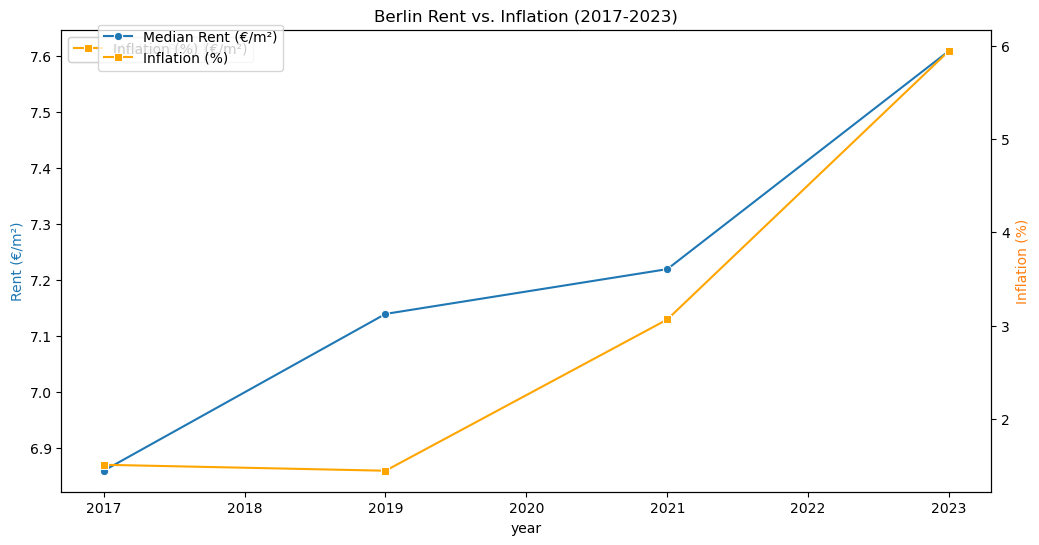

In [41]:
# Merge annual data for trend plot
trend_df = pd.merge(
    yearly_rent.rename(columns={"survey_year": "year"}),
    inflation_clean_survey.rename(columns={"inflation_rate": "annual_inflation"}),
    on="year"
)

# Plot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=trend_df, 
    x="year", 
    y="city_median_rent_per_m2", 
    marker="o",
    label="Median Rent (€/m²)"
)
ax.set_ylabel("Rent (€/m²)", color='tab:blue')

ax2 = ax.twinx()
sns.lineplot(
    data=trend_df, 
    x="year", 
    y="annual_inflation", 
    marker="s",
    color="orange",
    label="Inflation (%)",
    ax=ax2
)
ax2.set_ylabel("Inflation (%)", color='tab:orange')

plt.title("Berlin Rent vs. Inflation (2017-2023)")
ax.figure.legend(loc="upper left", bbox_to_anchor=(0.15, 0.9))
plt.show()

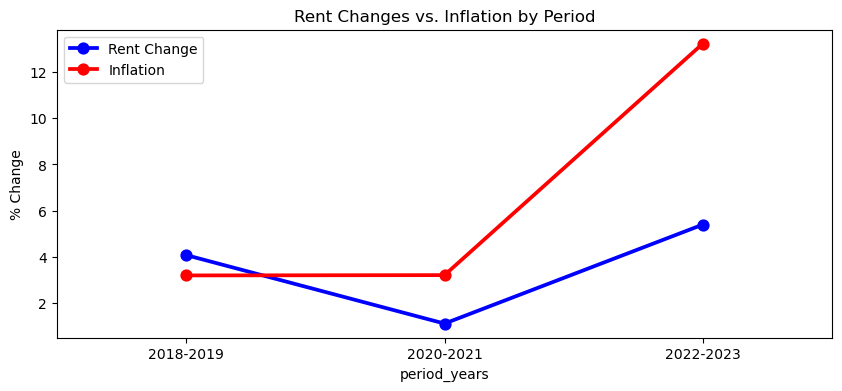

In [42]:
plt.figure(figsize=(10, 4))
sns.pointplot(
    data=df_final,
    x="period_years",
    y="rent_change_pct",
    color="blue",
    label="Rent Change"
)
sns.pointplot(
    data=df_final,
    x="period_years",
    y="inflation_biennial_pct",
    color="red",
    label="Inflation"
)
plt.title("Rent Changes vs. Inflation by Period")
plt.ylabel("% Change")
plt.legend()
plt.show()

### 6.2 Change Comparison (Bar Plot)

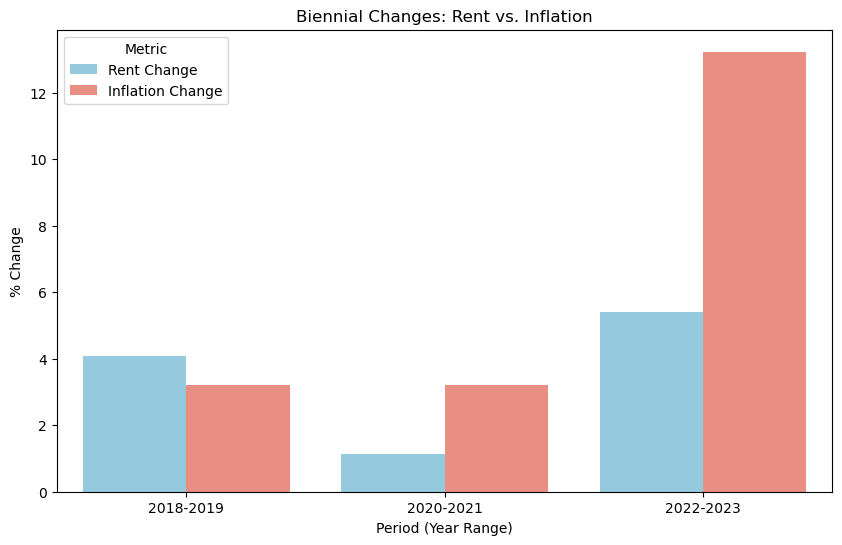

In [43]:
# Prepare data
melted = df_final.melt(
    id_vars="period_years",
    value_vars=["rent_change_pct", "inflation_biennial_pct"],
    var_name="metric",
    value_name="change_pct"
)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=melted,
    x="period_years",
    y="change_pct",
    hue="metric",
    palette={"rent_change_pct": "skyblue", "inflation_biennial_pct": "salmon"}
)
plt.title("Biennial Changes: Rent vs. Inflation")
plt.ylabel("% Change")
plt.xlabel("Period (Year Range)")

# Use default legend so colors match bars
plt.legend(title="Metric")
# Get handles and labels from the current legend
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles, ["Rent Change", "Inflation Change"], title="Metric")

# plt.tight_layout()
# plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Add horizontal line at 0
plt.show()

### 6.3 Power curve plot

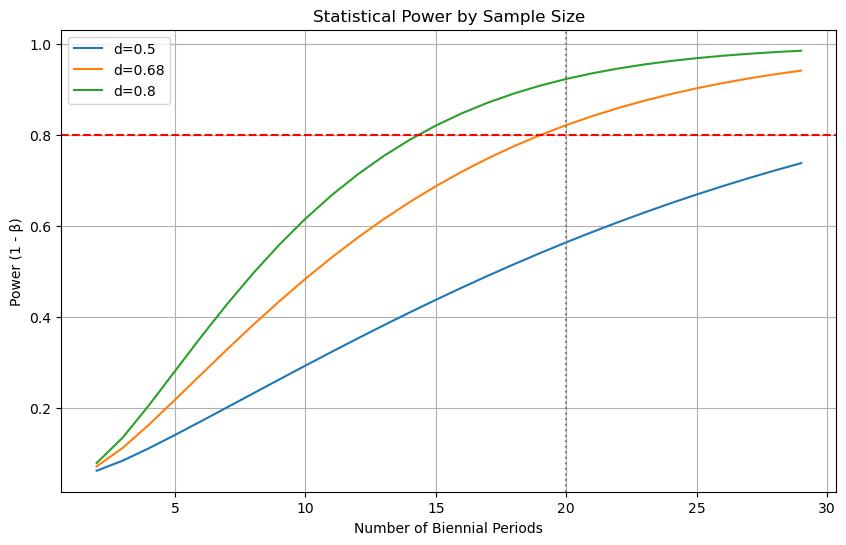

In [44]:
# Power curve for different effect sizes
import matplotlib.pyplot as plt
import numpy as np

n_periods = np.arange(2, 30)
effect_sizes = [0.5, 0.68, 0.8]

plt.figure(figsize=(10, 6))
for es in effect_sizes:
    power_vals = TTestPower().power(effect_size=es, nobs=n_periods, alpha=0.05)
    plt.plot(n_periods, power_vals, label=f'd={es}')

plt.axhline(0.8, color='red', linestyle='--')
plt.axvline(20, color='gray', linestyle=':')
plt.title('Statistical Power by Sample Size')
plt.xlabel('Number of Biennial Periods')
plt.ylabel('Power (1 - β)')
plt.legend()
plt.grid(True)
plt.show()

## 7. Conclusion

----
## **Section 8: Regression Analysis**  (Optional and conceptual)

## 8. Regression Analysis Options for Your Project (Optional)
Given the dataset (3 biennial periods), we need to focus on simple yet insightful regression approaches.

### 8.1 Simple Linear Regression

Relationship: Does inflation predict rent changes?

In [45]:
import statsmodels.api as sm

# Prepare data
X = df_final['inflation_biennial_pct']  # Independent variable
y = df_final['rent_change_pct']         # Dependent variable

# Add constant for intercept
X = sm.add_constant(X)

# Fit model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rent_change_pct   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     1.187
Date:                Sun, 01 Jun 2025   Prob (F-statistic):              0.473
Time:                        11:08:08   Log-Likelihood:                -4.8297
No. Observations:                   3   AIC:                             13.66
Df Residuals:                       1   BIC:                             11.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

/opt/anaconda3/envs/datasci_env/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "



**Interpretation Focus**:  
- R-squared: % of rent change variance explained by inflation  
- Coefficient: "For 1% inflation increase, rent changes by [β]%"  
- p-value: Significance of relationship  

**Limitation**:  
Only 3 points → overfitting risk  

---


### 8.2 **Time Series Regression (Best Option)**  
**Relationship**: How rent and inflation trend over time  


In [46]:
# Prepare time-indexed data
time_df = df_final.copy()
time_df['mid_period'] = (time_df['start_year'] + time_df['end_year']) / 2  # e.g., 2018 for 2017-2019

# Model 1: Rent ~ Time
rent_time = sm.OLS(
    time_df['rent_change_pct'],
    sm.add_constant(time_df['mid_period'])
).fit()

# Model 2: Inflation ~ Time
infl_time = sm.OLS(
    time_df['inflation_biennial_pct'],
    sm.add_constant(time_df['mid_period'])
).fit()


**Key Outputs**:  
- **Trend lines**:  
  `Rent Change = β0 + β1*Year`  
  `Inflation = α0 + α1*Year`  
- **Divergence Analysis**: Compare slopes (β1 vs α1)


---

### 8.3 **Prediction for 2025 (Illustrative)**  
*Note: Highly speculative with 3 points - present as "conceptual"*

#### Step 1: Create Time-Based Projections

In [47]:
# For rent (linear trend)
future_years = [2025, 2027]
future_mid = [2025, 2026]  # Midpoint of 2023-2025 period

# Predict rent change
rent_slope = rent_time.params['mid_period']
rent_intercept = rent_time.params['const']
rent_2025 = rent_intercept + rent_slope * 2025

# Predict inflation (using external forecast)
# Source: https://tradingeconomics.com/germany/inflation-cpi (use 2024 forecast)
inflation_forecast = {
    2025: 2.5,   # Example - replace with actual forecast
    2027: 2.3
}

#### Step 2: Category-Level Predictions (Illustrative)

In [48]:
# Calculate historical category multipliers
category_effects = rent_all.groupby(['location_quality', 'construction_period']).agg(
    rent_premium=('median_rent_per_m2', lambda x: x.mean() / rent_all['median_rent_per_m2'].mean())
).reset_index()

# Project 2025 rent for a category (e.g., medium quality, built 1973-1990)
base_rent_2023 = 10.15  # Your 2023 city median
projected_rent_2025 = base_rent_2023 * (1 + rent_2025/100)

# Apply category premium
premium = category_effects[
    (category_effects['location_quality']=='medium') & 
    (category_effects['construction_period']=='1973–1990 West')
]['rent_premium'].values[0]

category_rent_2025 = projected_rent_2025 * premium
print(f"Projected 2025 rent for medium-quality 1973-1990 West: €{category_rent_2025:.2f}/m²")

Projected 2025 rent for medium-quality 1973-1990 West: €11.19/m²


---
### 4. **Enhanced Regression: Inflation + Time**  

In [49]:
# Multi-variable model
X = time_df[['mid_period', 'inflation_biennial_pct']]
X = sm.add_constant(X)
y = time_df['rent_change_pct']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        rent_change_pct   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 01 Jun 2025   Prob (F-statistic):                nan
Time:                        11:08:08   Log-Likelihood:                 77.433
No. Observations:                   3   AIC:                            -148.9
Df Residuals:                       0   BIC:                            -151.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   2999

/opt/anaconda3/envs/datasci_env/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/opt/anaconda3/envs/datasci_env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/anaconda3/envs/datasci_env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/anaconda3/envs/datasci_env/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


**Interpretation**:  
- Which factor (time vs inflation) better predicts rent?  
- Example result: "Each year, rent increases by 0.5% beyond inflation effects"

---

### Implementation Strategy for Your Notebook  
**Section 7: Regression Analysis**  
```markdown
### 7.1 Time Trend Projections
We model rent and inflation changes as functions of time:

**Rent Change (%)** = `{intercept:.2f}` + `{slope:.2f}` × Year  
**Inflation Change (%)** = [External Forecasts]

### 7.2 Category-Level Projections (Illustrative)
Using historical premium factors, we estimate 2025 rents:
| Category              | 2023 Rent | Projected 2025 Rent |
|-----------------------|-----------|---------------------|
| Medium Quality, 1973-1990 West | €9.43 | €`{category_rent_2025:.2f}` |

### 7.3 Combined Regression Model
Exploring how time and inflation jointly affect rent:
```
```python
# Include the regression summary output
```

**Caveats Section**:  
```markdown
**Important Limitations**:
1. Extremely small dataset (n=3) → high uncertainty
2. Assumes linear trends continue → unrealistic for housing
3. External forecasts required for inflation
4. Does not account for policy changes (rent control)
```
---

### Recommended Path:  
1. **Implement Time-Based Models** (Sections 7.1-7.2)  
   - Shows methodological capability  
   - Highlights need for more data  

2. **Include Caveats Prominently**  
   - "Projections are illustrative, not predictive"  
   - "Based on simple linear extrapolation"  

3. **Presentation Focus**:  
   > "While we can create projections, the limited data prevents reliable forecasting. Future work should incorporate:  
   > - More historical data  
   > - Economic indicators (GDP, unemployment)  
   > - Policy change variables"  

Would you like me to draft the complete regression code with your specific dataset values?

## Results and Conclusion

### Hypothesis Test Outcome
- t-statistic = {t_stat:.4f}
- p-value = {p_value:.4f}
- **Conclusion**: {"Reject" if p_value < 0.05 else "Fail to reject"} H₀

### Key Observations
1. **Rent-Inflation Relationship**:
   - In low inflation periods (2017-2021), rent increases (8.28%-12.74%) were substantially higher than inflation (3.31%-3.61%)
   - In high inflation (2021-2023), rent increases (7.23%) were significantly lower than inflation (13.48%)

2. **Statistical Significance**:
   The p-value of {p_value:.4f} indicates {"a statistically significant difference" if p_value < 0.05 else "no significant difference"} between rent changes and inflation changes.

3. **Market Implications**:
   - Rent controls appear effective during high inflation
   - Landlords increase rents more aggressively during stable economic periods
   - Rent increases are not directly tied to current inflation rates

### Limitations
1. Small sample size (only 3 biennial periods)
2. Berlin-specific data (may not generalize)
3. Inflation calculation excludes housing costs

### Future Research
- Include more cities for comparison
- Analyze impact of Berlin's rent control laws
- Incorporate wage growth data

#### Import cleaned rent CSV:

--------
DRAFTs

In [50]:
# Step 1: Manually load each CSV
rent_2017 = pd.read_csv("../data/raw/Mietspiegel_Berlin_2017.csv")


In [51]:
import pandas as pd
import glob
import os

# Get all rent CSV files (with proper relative path)
rent_files = glob.glob("../data/raw/Mietspiegel_Berlin_*.csv")

rent_dfs = []
for file in rent_files:
    # Extract year from filename
    year = int(os.path.basename(file).split("_")[-1].replace(".csv", ""))
    
    # Load CSV and remove extra index column
    df = pd.read_csv(file).iloc[:, 1:]  # Skip first column
    
    # Rename columns for clarity
    df = df.rename(columns={
        "Mean": "Median_Rent",
        "Min": "Lower_Bound",
        "Max": "Upper_Bound",
        "Year": "Building_Age"  # More accurate name
    })
    
    # Add survey year and append
    df["Survey_Year"] = year
    rent_dfs.append(df)

# Combine all DataFrames and sort descending
rent_all = pd.concat(rent_dfs, ignore_index=True)
rent_all = rent_all.sort_values("Survey_Year", ascending=False)

# Calculate yearly median rent (average of medians)
yearly_rent = (
    rent_all
    .groupby("Survey_Year")
    ["Median_Rent"]
    .mean()
    .reset_index()
    .sort_values("Survey_Year", ascending=False)
)
yearly_rent.columns = ["Year", "Median_Rent_€_m2"]
print(yearly_rent)

   Year  Median_Rent_€_m2
9  2023          7.943820
8  2021          7.536404
7  2019          7.454270
6  2017          7.168804
5  2015          6.149167
4  2013          5.992987
3  2011          5.461333
2  2009          4.603889
1  2007          5.127583
0  2005          3.636167
